<a href="https://colab.research.google.com/github/jhc154/PatentLandscapeViz/blob/master/Patent_Analysis_Semiconductors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# import pandas
import pandas as pd
import os

In [0]:
# Analysis based on Google Patents Search
# Source: https://patents.google.com/?q=Field+Programmable+Gate+Array,Application+Specific+Integrated+Circuit&country=US&after=priority:20000101&status=GRANT&language=ENGLISH&type=PATENT&litigation=YES
# Search results as of: 5 MAY 2020

In [0]:
# change directory to wherever your csv file is
os.chdir('/content/gdrive/My Drive')

In [0]:
# create variables to point to a file to be analyzed, currently set to asic

asic = 'gp-search-20200505-172536-raw_with_claims.csv'
graphene = 'gp-search-20200505-172109-raw_with_claims.csv'

# read in the csv file containing patent data

df = pd.read_csv(asic, index_col=0)

import time # need to have date fields recognized as such

# priority date
df['priority date'] = pd.to_datetime(df['priority date'])
# filing date
df['filing/creation date'] = pd.to_datetime(df['filing/creation date'])
# publication date
df['publication date'] = pd.to_datetime(df['publication date'])
# grant date. Some are not granted, so we tell pandas to ignore if they won't turn into datetime format
df['grant date'] = pd.to_datetime(df['grant date'], errors = 'ignore')

In [0]:
# also change the col name from id to patent
df.rename(columns={'id':'patent'}, inplace=True)

In [0]:
# fix error related to float type error when trying to process these cols; make sure these cols are read in as string types

df['claim'] = df['claim'].astype(str)
df['classifications'] = df['classifications'].astype(str)

In [0]:
# Words that should be excluded from anaysis; patent claims generally contain similar words or 'terms of art' that are necessary for claim construction
# but profoundly useless for conveying the meaning of an invention. 

stop_list = ['based', 'having', 'material', 'materials','according','abstract','abstracts','acceptable','apparatus','apparatuses',\
             'body','cancel','claim','claims','claimed','following','classification',\
             'classifications','comprise','comprises','comprising','composition','optionally','compound',\
             'portion', 'portions', 'consisting','configure','configures','consist','consists','configured','dependent','desire','description',\
             'device','devices','disclose','disclosed','discloses','different', 'surface', 'using', 'substrate', 'surface', 'layer',\
             'embodiment','embodiments','example','examples','non', 'portion', 'selected',\
             'disposed', 'formed', 'forming','for example','herein','hide','include','includes','invention',\
             'inventions','inventions','method','produce','present','process','provide',\
             'provided','provides','plurality','said','say','system','systems',\
             'thereof','user','subject','subsequent', 'cite', 'cited',\
             'form','group','use', 'select', 'little', 'accord','first', 'second', 'third', 'fourth', 'fifth', 'sixth','seventh'] 

In [8]:
#import libraries and prep to clean and tokenize raw text


# install and import spacy (look up documentation for spacy)
import spacy

# import English package
from spacy.lang.en import English

# import string library
import string

# import regex to help clean text
import re

# import scikit learn package of English stop words 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# assign variable "punctuation" to list of punctuations from string package
punctuation = list(string.punctuation)

# assign variable "parser" to the English function
parser = English()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# Create a function to clean and tokenize raw text
def tokenizeText(text):
    # clean text using regex
    ## create a list of regex expressions and assign variable "separators"
    separators = ["\xa0\xa0\xa0\xa0", "\r", "\n",\
                  "\t", "n't", "'m", "'ll", '[^a-z ]'\
                 '[\s]+',r'[^\w]','^\d+\s|\s\d+\s|\s\d+$']
    
    # iterate over the list of separators
    for i in separators:
        # every time regex finds a match in the text of the claims, delete (replace it with space)
        text = re.sub(i, " ", text.lower())
    
    # parse text using Spacy
    tokens = parser(text)
    tokens = [tok.lemma_.strip() for tok in tokens]
    # get rid of words in the stop list
    
    return [tok for tok in tokens if len(tok) !=1 and tok not in stop]

In [0]:
# create function to turn the list of tokens into one body of text (corpus)
def text_processing(corp):
    # call the tokenizeText function we created above
    corp = tokenizeText(corp)
    return ' '.join(corp)

In [0]:
stop = set(list(stop_list) + list(ENGLISH_STOP_WORDS) + list(punctuation))

In [0]:
# apply the function for each row of texts in the text column of the dataframe
df['claim'] = df['claim'].apply(text_processing)
df['classifications'] = df['classifications'].apply(text_processing)

In [0]:
# remove white space from the cells containing classification data; to help with extracting the classification number
# this code has some bugs that need to be worked out, some cells are producing nan
df['classifications'] = df['classifications'].str.strip()


In [14]:
# extract the first part of classification cell, the number and create a temp DF to hold these
temp = df['classifications'].str.split(" ", n=1, expand=True).astype(str)
temp.head()

,0,1
0,g06f30,circuit design reconfigurable circuits field p...
1,g06q40,exchange stocks commodities derivatives curren...
2,h04l25,arrangements impedance matching view
3,h01l21,making insulator single crystalline silicon li...
4,h01l27,geometrical layout components computer aided d...


In [0]:
# replace df cols with the newly split classificationsNum and classification
df['classificationsNum'] = temp[0]
df.classifications = temp[1]

In [0]:
# Extract the numerical value from the cited by column (how many times this patent is cited)
# https://stackoverflow.com/questions/37683558/pandas-extract-number-from-string

df['citedBy'] = df.citedBy.str.extract('(\d+)')

In [17]:
# check handy work so far >>> cols from let to right
df.head()

,patent,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,claim,classifications,citedBy,classificationsNum
0,US-7587699-B2,Automated system for designing and developing ...,"Pixel Velocity, Inc.",David L. McCubbrey,2002-05-17,2006-05-10,2009-09-08,2009-09-08,https://patents.google.com/patent/US7587699B2/en,https://patentimages.storage.googleapis.com/US...,programming field programmable gate array fp...,circuit design reconfigurable circuits field p...,145,g06f30
1,US-7921046-B2,High speed processing of financial information...,Exegy Incorporated,"Scott Parsons, David E. Taylor, David Vincent ...",2006-06-19,2007-06-19,2011-04-05,2011-04-05,https://patents.google.com/patent/US7921046B2/en,https://patentimages.storage.googleapis.com/f7...,processing financial market data reconfigurab...,exchange stocks commodities derivatives curren...,167,g06q40
2,US-7064576-B1,Techniques for reducing leakage current in on-...,Altera Corporation,Simar Maangat,2003-08-20,2005-01-24,2006-06-20,2006-06-20,https://patents.google.com/patent/US7064576B1/en,https://patentimages.storage.googleapis.com/US...,integrated circuit impedance termination circ...,arrangements impedance matching view,17,h04l25
3,US-7402855-B2,Split-channel antifuse array architecture,Sidense Corp.,Wlodek Kurjanowicz,2004-05-06,2005-05-06,2008-07-22,2008-07-22,https://patents.google.com/patent/US7402855B2/en,https://patentimages.storage.googleapis.com/US...,anti fuse memory array anti fuse transistors ...,making insulator single crystalline silicon li...,150,h01l21
4,US-8533641-B2,Gate array architecture with multiple programm...,Baysand Inc.,"Jonathan C Park, Salah M Werfelli, Weizhi Kang...",2011-10-07,2011-10-07,2013-09-10,2013-09-10,https://patents.google.com/patent/US8533641B2/en,https://patentimages.storage.googleapis.com/7f...,custom integrated circuit fixed programmable ...,geometrical layout components computer aided d...,17,h01l27


In [0]:
#clean up white space, just making sure
df['title'] = df['title'].str.strip()
df['claim'] = df['claim'].str.strip()
df['classifications'] = df['classifications'].str.strip()
df['citedBy'] = df['citedBy'].str.strip()

In [19]:
#reset index, just making sure
df = df.reset_index(drop=True)
df.head()

,patent,title,assignee,inventor/author,priority date,filing/creation date,publication date,grant date,result link,representative figure link,claim,classifications,citedBy,classificationsNum
0,US-7587699-B2,Automated system for designing and developing ...,"Pixel Velocity, Inc.",David L. McCubbrey,2002-05-17,2006-05-10,2009-09-08,2009-09-08,https://patents.google.com/patent/US7587699B2/en,https://patentimages.storage.googleapis.com/US...,programming field programmable gate array fpg...,circuit design reconfigurable circuits field p...,145,g06f30
1,US-7921046-B2,High speed processing of financial information...,Exegy Incorporated,"Scott Parsons, David E. Taylor, David Vincent ...",2006-06-19,2007-06-19,2011-04-05,2011-04-05,https://patents.google.com/patent/US7921046B2/en,https://patentimages.storage.googleapis.com/f7...,processing financial market data reconfigurabl...,exchange stocks commodities derivatives curren...,167,g06q40
2,US-7064576-B1,Techniques for reducing leakage current in on-...,Altera Corporation,Simar Maangat,2003-08-20,2005-01-24,2006-06-20,2006-06-20,https://patents.google.com/patent/US7064576B1/en,https://patentimages.storage.googleapis.com/US...,integrated circuit impedance termination circu...,arrangements impedance matching view,17,h04l25
3,US-7402855-B2,Split-channel antifuse array architecture,Sidense Corp.,Wlodek Kurjanowicz,2004-05-06,2005-05-06,2008-07-22,2008-07-22,https://patents.google.com/patent/US7402855B2/en,https://patentimages.storage.googleapis.com/US...,anti fuse memory array anti fuse transistors a...,making insulator single crystalline silicon li...,150,h01l21
4,US-8533641-B2,Gate array architecture with multiple programm...,Baysand Inc.,"Jonathan C Park, Salah M Werfelli, Weizhi Kang...",2011-10-07,2011-10-07,2013-09-10,2013-09-10,https://patents.google.com/patent/US8533641B2/en,https://patentimages.storage.googleapis.com/7f...,custom integrated circuit fixed programmable r...,geometrical layout components computer aided d...,17,h01l27


In [0]:
# uncomment below to export cleaned data (review it or save for later to avoid reprocessing)
# df.to_csv('gp-search-20200505-172109-raw_with_claims_cleaned.csv')

In [0]:
## at this point, text has been processed and cleaned, ready for analysis

In [20]:
# TF-IDF vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
                  
  
# min_df = ignore terms that appear in less than n% of patents
# max_df = ignore temrs that appear in more than n% of patents

tfidf_vectorizer = TfidfVectorizer(
    min_df=0.1, # interesting to see how drastically the model changes if this becomes 0.1
    max_df=0.5, # also change max df to .25 while min df is 0.1 to compare
    max_features = 5000, 
    stop_words = 'english')
    
tfidf_matrix = tfidf_vectorizer.fit_transform(df.claim)
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [0]:
# find cosine similarities for recommendation engine (Data Camp)

from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [0]:
# Generate mapping between titles and index (Data Camp)

indices = pd.Series(df.index, index=df['patent'])

def get_recommendations(patent, cosine_sim, indices):
    # Get index of patent that matches title
    idx = indices[patent]
    # Sort the patents based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar matches
    sim_scores = sim_scores[1:11]
    # Get the indices
    patent_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar movies
    return df[['patent','title','classificationsNum']].iloc[patent_indices]

In [24]:
# test recommender, input patent ID and return similar patents

# analysis: is the algorithm right if similar classificationsNum are returned or is it finding patents that are more related than they seem?
# argA: classificationsNum are already a form of classification about the patent document - one should expect to see very similar numbers
# argB: the similiarities of the actual patents indiciate more similarity than their classification number - this is a new insight. 
# How does argument A compare to argument b?

print(get_recommendations('US-8533641-B2', cosine_sim, indices))

              patent  ... classificationsNum
6      US-8788984-B2  ...             h01l27
2209   US-7012463-B2  ...              h03f3
296   US-10487991-B2  ...              f21k9
7586   US-7977797-B2  ...             h01l21
7904  US-10547186-B2  ...              h02j7
1021   US-8649906-B2  ...             b25j19
1267   US-8062968-B1  ...             h01l23
1478   US-7139181-B2  ...              g06f1
1473   US-7593203-B2  ...              h05k1
7282   US-7880612-B2  ...             g08b13

[10 rows x 3 columns]


In [0]:
# set number of clusters; start at 8 and then tune down based on elbow analysis
k = 8

In [0]:
# pca analysis of tf_idf_matrix

from sklearn.decomposition import PCA

pca = PCA(n_components=k)
principalComponents = pca.fit_transform(tfidf_matrix.todense())
PCA_components = pd.DataFrame(principalComponents)

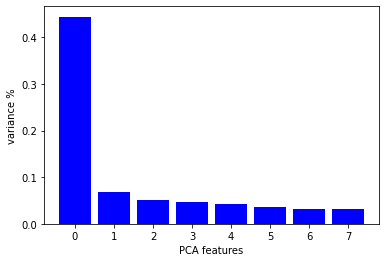

In [40]:
# plot pca analysis variance
import matplotlib.pyplot as plt

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features);

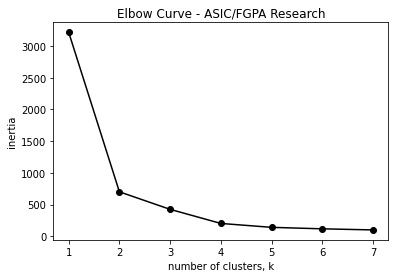

In [41]:
#run elbow analysis; identify ideal # clusters with KMeans and PCA
from sklearn.cluster import KMeans

ks = range(1, k)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Elbow Curve - ASIC/FGPA Research')

plt.savefig('PatentViz-ASIC-FGPA.png')
plt.show()

In [42]:
# fit tf_idf matrix to KMeans clusters; accept all values (runs much faster in colab than on my laptop)
km = KMeans(n_clusters=k)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# send KMeans cluster labels to list 'clusters'
# http://brandonrose.org/clustering

from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [0]:
# add cluster values to dataframe
df['cluster'] = clusters

# need to make citedBy number as int type
df['citedBy'] = df['citedBy'].fillna(0).astype(int)

#df['DataFrame Column'] = df['DataFrame Column'].fillna(0)
grouped = df['citedBy'].groupby(df['cluster'])

grouped.mean()

cluster
0    12.481924
1    17.318634
2    11.057901
3    14.690122
4    11.464489
5    12.036878
6     9.294695
Name: citedBy, dtype: float64

In [0]:
# create an empty dict for cluster names
cluster_names = {}

In [45]:
# loop through vectorized terms and centroidst to create list of cluster names
# BUG > Can't figure out how to send all terms[ind] values to the dict; currently writing over to produce last values of each array

# https://pythonprogramminglanguage.com/kmeans-text-clustering/

terms = tfidf_vectorizer.get_feature_names()

order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(k):
    print("Cluster %d terms:" % i, end=''),

    
    for ind in order_centroids[i, :2]:
        print(' %s' % terms[ind], end=','),

        cluster_names[i] = 'Cluster %d ' % i, terms[ind]

    print() #add whitespace
    print() #add whitespace
    

Cluster 0 terms: nan, time,

Cluster 1 terms: circuit, connected,

Cluster 2 terms: control, connected,

Cluster 3 terms: including, connected,

Cluster 4 terms: data, processor,

Cluster 5 terms: information, computer,

Cluster 6 terms: signal, circuit,



In [50]:
# Save cluster and terms in a dict for charting later on
# This is the bug.
# Should be: ('Cluster 0 ','conductive','displayrmula'),...
# for now, this works :(
    
cluster_names

{0: ('Cluster 0 ', 'time'),
 1: ('Cluster 1 ', 'connected'),
 2: ('Cluster 2 ', 'connected'),
 3: ('Cluster 3 ', 'connected'),
 4: ('Cluster 4 ', 'processor'),
 5: ('Cluster 5 ', 'computer'),
 6: ('Cluster 6 ', 'circuit')}

In [0]:
# set up colors per clusters using a dict
# http://brandonrose.org/clustering
cluster_colors = {0: '#EC7063', 1: '#C39BD3', 2: '#7FB3D5', 3: '#48C9B0', 4: '#F1C40F', 5:'#BDC3C7', 6:'#000000'}

In [0]:
# calculate cosine similiarity
# http://brandonrose.org/clustering
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [49]:
# transform the matrix to 2d for plotting
# takes a while to run, but still really fast in Google Colab
# http://brandonrose.org/clustering

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [0]:
# send df patent col to a list for later when plotting
titles = df['patent'].values.tolist()

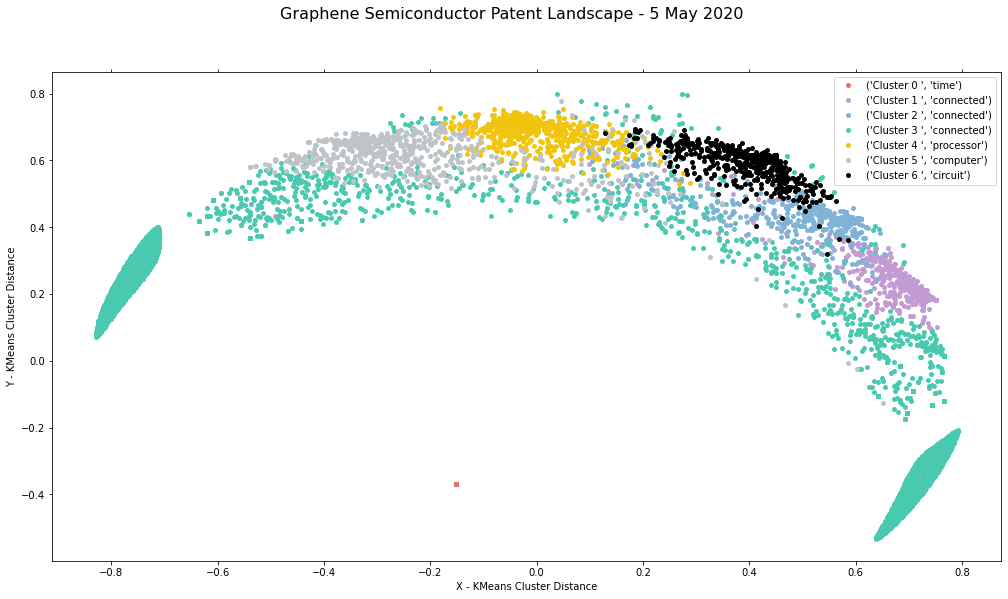

In [52]:
# plot the data!
# http://brandonrose.org/clustering

# some ipython magic to show the matplotlib plots inline
%matplotlib inline 

# create data frame that has the result of the MDS plus the cluster numbers and titles
df_plot = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

# group by cluster
groups = df_plot.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size

#added a figure title
fig.suptitle('Graphene Semiconductor Patent Landscape - 5 May 2020', fontsize=16)
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#added x and y labels
ax.set_xlabel('X - KMeans Cluster Distance')
ax.set_ylabel('Y - KMeans Cluster Distance')

# commented out labeling all features (too many!)
#add label in x,y position with the label as the title
#for i in range(len(df_plot)):
#   ax.text(df_plot.iloc[i]['x'], df_plot.iloc[i]['y'], df_plot.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [53]:
# to use d3, install the package

!pip install mpld3

     |████████████████████████████████| 798kB 2.7MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=e91f2f8c41e2cd588642c4634fe420410b6c8413862b6e0944375064d10e7035
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [0]:
# define custom toolbar location

# http://brandonrose.org/clustering
import mpld3

class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [55]:
# plot interactive chart
# http://brandonrose.org/clustering

import mpld3

#create data frame that has the result of the MDS plus the cluster numbers and titles
df_plot2 = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df_plot2.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)


In [57]:
# one way to run stats on the citedBy column
df.agg({'citedBy':['min','max','median','mean']})



,citedBy
median,29.0


In [0]:
# better way to analyze this table with SQL
import sqlite3

In [0]:
# establish sql connection from python
conn = sqlite3.connect('db1.db')
c = conn.cursor()

In [0]:
# create the table in SQL; send data from python dataframe to this sql table
c.execute('CREATE TABLE PATENTS (Patent text, Title text, Assignee text, PriorityDate date, CitedBy number, Classification text, Cluster number)')
conn.commit()

In [0]:
# create a new DF that contains all the data, minus the claim and URLs
df_sql = df[['patent', 'title', 'assignee', 'priority date', 'citedBy', 'classificationsNum', 'cluster']]

In [0]:
# send the dataframe to sql table
df_sql.to_sql('PATENTS', conn, if_exists='replace', index = False)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [0]:
# save this data to csv for analysis elsewhere (and to save it for future use); I analyzed this further in tableau

df_sql.to_csv('Patents_Graphene_20200507_2.csv')

In [0]:
# using query features to double check results of highly cited patent
c.execute('''
SELECT * 
FROM PATENTS2 
WHERE Patent="US-6475606-B2"
''')
for row in c.fetchall():
  print(row)

In [0]:
# using query features to double check results of highly cited patent
c.execute('''
SELECT * 
FROM PATENTS 
WHERE Cluster=0
LIMIT (20)
''')
for row in c.fetchall():
  print(row)